# Step.2 KGB(known Good/Bad)训练，用于检测拒绝集(训练集中的unknown标签)

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import atecml.data
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

class BasicModel(object):
    """Parent class of basic models"""
    def train(self, x_train, y_train, x_val, y_val):
        """return a trained model and eval metric o validation data"""
        pass
    
    def predict(self, model, x_test):
        """return the predicted result"""
        pass
    
    def get_oof(self, x_train, y_train, x_test, n_folds = 5):
        """K-fold stacking"""
        num_train, num_test = x_train.shape[0], x_test.shape[0]
        oof_train = np.zeros((num_train,)) 
        oof_test = np.zeros((num_test,))
        oof_test_all_fold = np.zeros((num_test, n_folds))
        aucs = []
        model_list = []
        
        for i in range(0,n_folds):
            
            val_index = DateFold[5] #始终用最后20%验证            
            train_index = list(all_list - DateFold[i])
                            
            print('{0} fold, train {1}, val {2}'.format(i, len(train_index), len(val_index)))
            x_tra, y_tra = x_train[train_index], y_train[train_index]
            x_val, y_val = x_train[val_index], y_train[val_index]
            
            #Over_sample
            X_resampled, y_resampled = SMOTE().fit_sample(x_tra,y_tra)
            model, auc = self.train(X_resampled, y_resampled, x_val, y_val)
            #model, auc = self.train(x_tra, y_tra, x_val, y_val)
            aucs.append(auc)
            model_list.append(model)
            oof_train[val_index] = self.predict(model, x_val)
            oof_test_all_fold[:, i] = self.predict(model, x_test)
        oof_test = np.mean(oof_test_all_fold, axis=1)
        print('all aucs {0}, average {1}'.format(aucs, np.mean(aucs)))
        return oof_train, oof_test,model_list

import lightgbm as lgb
class LGBClassifier(BasicModel):
    '''
    ' 调参范围
    'num_leaves':range(35,65,5)
    'learning_rate':[0.01,0.05,0.1,0.3,0.5,0.7]
    'min_child_weight':range(1,6,2)
    'max_depth':range(3,10,2),
    'subsample':[i/10.0 for i in range(6,10)],正常直接设置为1
    'colsample_bytree':[i/10.0 for i in range(6,10)]，正常直接设置为1
    'reg_alpha','reg_lambda':[1e-5, 1e-2, 0.1, 1, 2,2.5,3]
    '''
    def __init__(self,boost_type,boost_round=1000,early_stop=100,pos_weight=1):
        self.num_boost_round = boost_round
        self.early_stopping_rounds = early_stop
        self.params = {
            'task': 'train',
            'boosting_type': boost_type,
            'colsample_bytree': 0.7,
            'learning_rate': 0.05,
            'max_bin': 255,
            'max_depth': -1,
            'metric': {'auc'},
            'min_child_samples': 600,
            'min_child_weight': 0.05,
            'min_split_gain': 0,
            'nthread': 40,
            'num_leaves': 80,
            'objective': 'binary',
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            #'is_unbalance':'true',
            'scale_pos_weight': pos_weight,
            'subsample': 0.85,
            'subsample_for_bin': 200000,
            'subsample_freq': 1,
            'use_missing': 'true',
            'verbose' : -1,
            }
        print(self.params)
        
    def train(self, x_train, y_train, x_val, y_val):
        print('train with lgb model')
        lgbtrain = lgb.Dataset(x_train, y_train)
        lgbval = lgb.Dataset(x_val, y_val)
        model = lgb.train(self.params, 
                          lgbtrain,
                          valid_sets=lgbval, 
                          verbose_eval = 50,
                          num_boost_round = self.num_boost_round,
                          early_stopping_rounds = self.early_stopping_rounds)
        return model, model.best_score['valid_0']['auc']
    
    def predict(self, model, x_test):
        print('test with lgb model')
        return model.predict(x_test, num_iteration=model.best_iteration)

def stack_layer1_result(X_train,rf_model_list,gbdt_model_list,dart_model_list):
    with atecml.data.timer('Classification: Building Layer-1 Stack'):
        rf_input_list = []
        for idx in tqdm(range(len(rf_model_list))):
            model = rf_model_list[idx]
            _temp_df = model.predict(X_train,num_iteration=model.best_iteration)
            rf_input_list.append(pd.DataFrame(_temp_df))
        rf_oof_predict= np.array(pd.concat(rf_input_list,ignore_index=True,axis=1).mean(axis=1))    
    
        gbdt_input_list = []
        for idx in tqdm(range(len(gbdt_model_list))):
            model = gbdt_model_list[idx]
            _temp_df = model.predict(X_train,num_iteration=model.best_iteration)
            gbdt_input_list.append(pd.DataFrame(_temp_df))
        gbdt_oof_predict= np.array(pd.concat(gbdt_input_list,ignore_index=True,axis=1).mean(axis=1))
        
        
        dart_input_list = []
        for idx in tqdm(range(len(dart_model_list))):
            model = dart_model_list[idx]
            _temp_df = model.predict(X_train,num_iteration=model.best_iteration)
            dart_input_list.append(pd.DataFrame(_temp_df))
        dart_oof_predict= np.array(pd.concat(dart_input_list,ignore_index=True,axis=1).mean(axis=1))
    
    input_predict = [rf_oof_predict, gbdt_oof_predict, dart_oof_predict] 
    stacked_predict = np.concatenate([f.reshape(-1, 1) for f in input_predict], axis=1)
    
    return stacked_predict



In [3]:
#训练集为第一步build的纬度提升矩阵，并过滤掉unknown标签
data = pd.read_pickle('./01_train.dat')
train_df = data[data['label']!=-1].reset_index(drop=True)

#最终预测的测试集为unknown标签
val_df = data[data['label']==-1].reset_index(drop=True)

predictors = ['n_f262', 'n_f108', 'n_f279', 'n_f151', 'n_f284', 'n_f191', 'n_f83', 'n_f200', 'n_f32', 'n_f255', 'n_f246', 'n_f109', 'n_f192', 'n_f34', 'n_f105', 'n_f107', 'n_f7', 'n_f259', 'n_f210', 'n_f95', 'n_f98', 'n_f202', 'n_f6', 'n_f170', 'n_f277', 'n_f147', 'n_f139', 'n_f173', 'n_f80', 'n_f160', 'n_f257', 'n_f247', 'n_f92', 'n_f24', 'n_f194', 'n_f280', 'n_f297', 'n_f41', 'n_f274', 'n_f237', 'n_f175', 'n_f205', 'n_f182', 'n_f62', 'n_f116', 'n_f183', 'n_f81', 'n_f199', 'n_f236', 'n_f154', 'n_f148', 'n_f207', 'n_f209', 'n_f76', 'n_f72', 'n_f238', 'n_f44', 'n_f64', 'n_f260', 'n_f84', 'n_f178', 'n_f137', 'n_f122', 'n_f267', 'n_f125', 'n_f65', 'n_f157', 'n_f102', 'n_f146', 'n_f128', 'n_f258', 'n_f57', 'n_f176', 'n_f9', 'n_f272', 'n_f150', 'n_f187', 'n_f123', 'n_f124', 'n_f144', 'n_f18', 'n_f152', 'n_f171', 'n_f168', 'n_f138', 'n_f119', 'n_f66', 'n_f93', 'n_f42', 'n_f121', 'n_f134', 'n_f40', 'n_f117', 'n_f136', 'n_f35', 'n_f217', 'n_f283', 'n_f100', 'n_f135', 'n_f193', 'n_f201', 'n_f129', 'n_f69', 'n_f11', 'n_f33', 'n_f37', 'n_f291', 'n_f86', 'n_f71', 'n_f82', 'n_f181', 'n_f261', 'n_f271', 'n_f234', 'n_f49', 'n_f290', 'n_f56', 'n_f38', 'n_f20', 'n_f156', 'n_f114', 'n_f140', 'n_f292', 'n_f265', 'n_f244', 'n_f266', 'n_f169', 'n_f158', 'n_f54', 'n_f31', 'n_f185', 'n_f29', 'n_f22', 'n_f167', 'n_f39', 'n_f295', 'n_f254', 'n_f52', 'n_f189', 'n_f188', 'n_f278', 'n_f73', 'n_f235', 'n_f198', 'n_f177', 'n_f288', 'n_f263', 'n_f190', 'n_f131', 'n_f12', 'n_f120', 'n_f245', 'n_f256', 'n_f96', 'n_f127', 'n_f48', 'n_f110', 'n_f59', 'n_f293', 'n_f55', 'n_f101', 'n_f47', 'n_f268', 'n_f14', 'n_f196', 'n_f197', 'n_f155', 'n_f70', 'n_f25', 'n_f3', 'n_f68', 'n_f21', 'n_f248', 'n_f296', 'n_f91', 'n_f206', 'n_f215', 'n_f159', 'n_f115', 'n_f27', 'n_f75', 'n_f5', 'n_f58', 'n_f133', 'n_f216', 'n_f282', 'n_f16', 'n_f103', 'n_f4', 'n_f275', 'n_f74', 'n_f99', 'n_f43', 'n_f153', 'n_f180', 'n_f113', 'n_f132', 'n_f30', 'n_f50', 'n_f85', 'n_f26', 'n_f15', 'n_f172', 'n_f145', 'n_f53', 'n_f106', 'n_f97', 'n_f90', 'n_f130', 'n_f273', 'n_f23', 'n_f79', 'n_f143', 'n_f149', 'n_f195', 'n_f126', 'n_f36', 'n_f63', 'n_f67', 'n_f186', 'n_f281', 'n_f141', 'n_f269', 'n_f88', 'n_f77', 'n_f287', 'n_f166', 'n_f118', 'n_f286', 'n_f51', 'n_f17', 'n_f294', 'n_f203', 'n_f276', 'n_f61', 'n_f104', 'n_f87', 'n_f208', 'n_f270', 'n_f184', 'n_f111', 'n_f89', 'n_f289', 'n_f218', 'n_f179', 'n_f285', 'n_f204', 'n_f1', 'n_f264', 'n_f28', 'n_f142', 'n_NaN_LIST', 'n_f174', 'n_f94', 'n_f46', 'n_f78', 'n_f112', 'mean']

target = 'label'
DateFold={}

DateFold[0] = set(atecml.data.filter_date(train_df,start_date='2017-09-05',end_date='2017-09-12').index)
DateFold[1] = set(atecml.data.filter_date(train_df,start_date='2017-09-13',end_date='2017-09-20').index)
DateFold[2] = set(atecml.data.filter_date(train_df,start_date='2017-09-21',end_date='2017-09-28').index)
DateFold[3] = set(atecml.data.filter_date(train_df,start_date='2017-09-29',end_date='2017-10-06').index)
DateFold[4] = set(atecml.data.filter_date(train_df,start_date='2017-10-07',end_date='2017-10-14').index)
DateFold[5] = list(atecml.data.filter_date(train_df,start_date='2017-10-15',end_date='2017-11-24').index)

all_list = set(train_df.index) - set(DateFold[5])
len(all_list),len(DateFold[5])

(631141, 358865)

In [4]:
x_train = np.array(train_df[predictors])
y_train = np.array(train_df[target])
x_test = np.array(val_df[predictors])
print(x_train.shape, y_train.shape, x_test.shape)

(990006, 258) (990006,) (4725, 258)


In [5]:
num_pos = np.sum(train_df[target])  
num_neg = x_train.shape[0]- num_pos
scale_pos_weight =  num_neg/num_pos
print(num_pos,num_neg,scale_pos_weight)

12122 977884 80.67018643788154


In [6]:
num_boost_round = 2000
num_early_stop = 100

In [7]:
# get output of first layer models and construct as input for the second layer          
rf_classifier = LGBClassifier(boost_type='rf',boost_round=num_boost_round,early_stop=num_early_stop,pos_weight= scale_pos_weight)
rf_oof_train, rf_oof_test,rf_model_list = rf_classifier.get_oof(x_train, y_train, x_test)
print(rf_oof_train.shape, rf_oof_test.shape)  


{'learning_rate': 0.05, 'num_leaves': 80, 'metric': {'auc'}, 'min_child_samples': 600, 'reg_lambda': 0.1, 'max_bin': 255, 'use_missing': 'true', 'nthread': 40, 'boosting_type': 'rf', 'min_split_gain': 0, 'subsample_for_bin': 200000, 'subsample': 0.85, 'objective': 'binary', 'scale_pos_weight': 80.67018643788154, 'min_child_weight': 0.05, 'task': 'train', 'colsample_bytree': 0.7, 'max_depth': -1, 'reg_alpha': 0.1, 'subsample_freq': 1, 'verbose': -1}
0 fold, train 498238, val 358865
train with lgb model
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.946576
[100]	valid_0's auc: 0.95176
[150]	valid_0's auc: 0.953466
[200]	valid_0's auc: 0.953585
[250]	valid_0's auc: 0.953543
Early stopping, best iteration is:
[173]	valid_0's auc: 0.953654
test with lgb model
test with lgb model
1 fold, train 506877, val 358865
train with lgb model
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.945122
[100]	valid_0's auc: 0.946619
[

In [8]:
gbdt_classifier = LGBClassifier(boost_type='gbdt',boost_round=num_boost_round,early_stop=num_early_stop,pos_weight= scale_pos_weight)
gbdt_oof_train, gbdt_oof_test,gbdt_model_list = gbdt_classifier.get_oof(x_train, y_train, x_test)
print(gbdt_oof_train.shape, gbdt_oof_test.shape)  

dart_classifier = LGBClassifier(boost_type='dart',boost_round=num_boost_round,early_stop=num_early_stop,pos_weight= scale_pos_weight)
dart_oof_train, dart_oof_test,dart_model_list = dart_classifier.get_oof(x_train, y_train, x_test)
print(dart_oof_train.shape, dart_oof_test.shape)    

{'learning_rate': 0.05, 'num_leaves': 80, 'metric': {'auc'}, 'min_child_samples': 600, 'reg_lambda': 0.1, 'max_bin': 255, 'use_missing': 'true', 'nthread': 40, 'boosting_type': 'gbdt', 'min_split_gain': 0, 'subsample_for_bin': 200000, 'subsample': 0.85, 'objective': 'binary', 'scale_pos_weight': 80.67018643788154, 'min_child_weight': 0.05, 'task': 'train', 'colsample_bytree': 0.7, 'max_depth': -1, 'reg_alpha': 0.1, 'subsample_freq': 1, 'verbose': -1}
0 fold, train 498238, val 358865
train with lgb model
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.966623
[100]	valid_0's auc: 0.977913
[150]	valid_0's auc: 0.979268
[200]	valid_0's auc: 0.980216
[250]	valid_0's auc: 0.980502
[300]	valid_0's auc: 0.980749
[350]	valid_0's auc: 0.980811
[400]	valid_0's auc: 0.980881
[450]	valid_0's auc: 0.980765
Early stopping, best iteration is:
[377]	valid_0's auc: 0.981031
test with lgb model
test with lgb model
1 fold, train 506877, val 358865
train with lgb model


In [9]:
stacked_train = stack_layer1_result(x_train,rf_model_list,gbdt_model_list,dart_model_list)
stacked_test = stack_layer1_result(x_test,rf_model_list,gbdt_model_list,dart_model_list)

  0%|          | 0/5 [00:00<?, ?it/s]

[2018-07-04 01:06:05][Classification: Building Layer-1 Stack] Begin ...


  0%|          | 0/5 [00:00<?, ?it/s]

[2018-07-04 01:07:31][Classification: Building Layer-1 Stack] End   ...[Elapsed: 85.32s]
[2018-07-04 01:07:31][Classification: Building Layer-1 Stack] Begin ...


100%|██████████| 5/5 [00:00<00:00, 22.81it/s]

[2018-07-04 01:07:31][Classification: Building Layer-1 Stack] End   ...[Elapsed: 0.45s]


Ant-Score: 0.4736842105263158


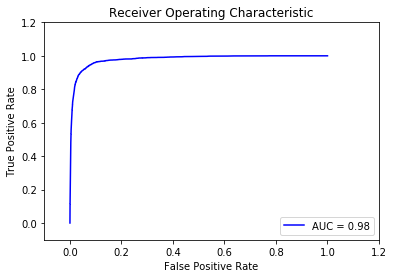

In [10]:
# use XGBOOST  as the model of the second layer
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(
 learning_rate =0.05,
 n_estimators=200,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 scoring='roc_auc',
 scale_pos_weight= scale_pos_weight,
 nthread=40,
 seed=27)


# split for validation
n = int(stacked_train.shape[0] * 0.8)
x_tra, y_tra = stacked_train[:n], y_train[:n]
x_val, y_val = stacked_train[n:], y_train[n:]
model.fit(x_tra,y_tra)
y_pred = pd.DataFrame(model.predict_proba(x_val))[1]

_f1,_f2,_f3 = atecml.data.accuracy_validation(y_val,y_pred)

In [11]:
# predict on test data
final_model = XGBClassifier(
 learning_rate =0.05,
 n_estimators=200,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 scoring='roc_auc',
 scale_pos_weight= scale_pos_weight,
 nthread=40,
 seed=27)


final_model.fit(stacked_train, y_train)
test_prediction = final_model.predict_proba(stacked_test)

result=pd.DataFrame()
result['id'] = val_df['id']
result['score'] = pd.DataFrame(test_prediction)[1]
result.to_pickle('./reject_inf.dat')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2d41452b0>]],
      dtype=object)

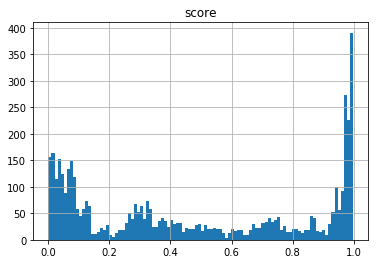

In [12]:
result.hist(bins=100)

In [13]:
len(result[result.score > 0.1])

3465

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc252036be0>]],
      dtype=object)

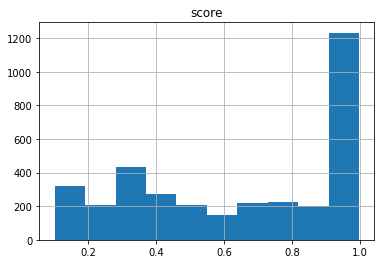

In [14]:
result[result.score > 0.1].hist()

In [15]:
result

,id,score
0,3c4b3baa09510eec473f45079c7c7977fc01fdfed93a8b...,0.019885
1,643b560780177054c375bd2ddd8a1ac6b99b728f016c75...,0.939361
2,addd09c73d0bfa3d98e252865c3343b534db2f0701e089...,0.354707
3,f8e66a38649c631bc205bd9f5cb953e214b17a3d9c80f2...,0.078744
4,61dacd672d0d12112ae4c5a9f0aa7d348c9566ba60bda3...,0.032886
5,bbd743c945e39779d7136f90dcd6e005b04d6660dd65ec...,0.979276
6,072a5f1007ec94ff4e6547783ec3dff4c72073dcfe5dfa...,0.027117
7,3842de26f717890858813543c6938c0fdb346b3e3fc715...,0.077910
8,1ac41ee380516d13d2692b74eb08e7b33135fe8b745ca8...,0.696117
9,1e06c933127058d1d88c63084522d4aa19dd0d55bc61ee...,0.955211
